In [27]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Input, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras import Model
#import tensorflow_datasets as tfds
print(tf.__version__)

2.4.0


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/uashogeschoolutrecht/tmoi-ml-19/blob/master/lesson%205/deeplearn3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [22]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [23]:
!pip install keras-tuner

In [24]:
import kerastuner as kt

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   cache_dir = '~/shared',
                                   cache_subdir = '',
                                   untar=True)

In [5]:
# size in MB
!du -mh $data_dir

40M	/tmp/.keras/flower_photos/roses
54M	/tmp/.keras/flower_photos/sunflowers
48M	/tmp/.keras/flower_photos/dandelion
55M	/tmp/.keras/flower_photos/tulips
35M	/tmp/.keras/flower_photos/daisy
230M	/tmp/.keras/flower_photos


In [6]:
# amount of files
!find $data_dir -type f | wc -l

3671


In [7]:
BATCH_SIZE = 32
img_height = 180
img_width = 180
IMAGE_SIZE = (img_height, img_width)

In [8]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=IMAGE_SIZE,
#   batch_size=BATCH_SIZE)

# valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=IMAGE_SIZE,
#   batch_size=BATCH_SIZE)

# class_names = train_ds.class_names
# print(class_names)
# NCLASSES = len(class_names)

In [9]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

Interpolation: method used to resample the image if the target size is different from that of the loaded image. Supported methods are "nearest", ["bilinear"](https://en.wikipedia.org/wiki/Bilinear_interpolation), and "bicubic".

In [10]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)


Found 731 images belonging to 5 classes.


In [11]:
do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 2939 images belonging to 5 classes.


In [12]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# valid_datagen = ImageDataGenerator(**datagen_kwargs)
# valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

# train_datagen = ImageDataGenerator(
#       #rotation_range=10,
#       #horizontal_flip=True,
#       #width_shift_range=0.2, 
#       #height_shift_range=0.2,
#       #zoom_range=0.2,
#       **datagen_kwargs)

# train_generator = train_datagen.flow_from_directory(
#     data_dir, subset="training", shuffle=True, **dataflow_kwargs)

In [13]:
class_names = train_generator.class_indices
print(class_names)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [14]:
train_generator.num_classes

5

In [15]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Explore dataset

(32, 180, 180, 3)
(32, 5)
[0. 0. 1. 0. 0.]


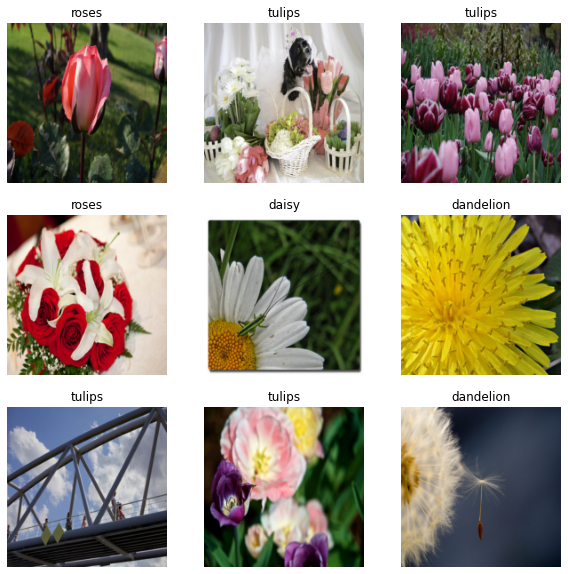

In [16]:
import matplotlib.pyplot as plt
inv_map = {v: k for k, v in class_names.items()}
plt.figure(figsize=(10, 10))
for image, label in train_generator:
  print(image.shape)
  print(label.shape)
  print(label[0])
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(inv_map[np.argmax(label[i])])
    plt.axis("off")
  break

In [40]:
model = tf.keras.Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(train_generator.num_classes)
])

In [44]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [45]:
%%time
model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=15
)

Epoch 1/10
92/92 [==============================] - 15s 156ms/step - loss: 1.6043 - accuracy: 0.2414 - val_loss: 1.5935 - val_accuracy: 0.2298
Epoch 2/10
92/92 [==============================] - 14s 155ms/step - loss: 1.5767 - accuracy: 0.2736 - val_loss: 1.4931 - val_accuracy: 0.3653
Epoch 3/10
92/92 [==============================] - 14s 150ms/step - loss: 1.4715 - accuracy: 0.3613 - val_loss: 1.4432 - val_accuracy: 0.3776
Epoch 4/10
92/92 [==============================] - 14s 150ms/step - loss: 1.4332 - accuracy: 0.3518 - val_loss: 1.4365 - val_accuracy: 0.3653
Epoch 5/10
92/92 [==============================] - 14s 149ms/step - loss: 1.4197 - accuracy: 0.3738 - val_loss: 1.4221 - val_accuracy: 0.3830
Epoch 6/10
92/92 [==============================] - 14s 149ms/step - loss: 1.4020 - accuracy: 0.3848 - val_loss: 1.4144 - val_accuracy: 0.3940
Epoch 7/10
92/92 [==============================] - 14s 149ms/step - loss: 1.3659 - accuracy: 0.3978 - val_loss: 1.4118 - val_accuracy: 0.3899

In [ ]:
model.summary()

In [60]:
def build_model(hp):
    input = Input(shape = IMAGE_SIZE + (3,))
    
    x = Rescaling(1./255)(input)
    
    filters1 = hp.Int('filters1', 16, 32, 4)
    #x = Conv2D(filters, 1, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters1, 3, activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    
    filters2 = hp.Int('filters2', 16, 64, 8)
    for i in range(hp.Int('conv_layers', 0, 3)):
        #x = Conv2D(filters, 1, strides=1, padding='same', activation='relu')(x)
        x = Conv2D(filters2, 3, activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 512, 64)

    x = Dense(units, activation='relu')(flat)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation='relu')(x)

    drops = hp.Float('drops', 0.05, 0.4)
    x=Dropout(drops)(x)
    output = Dense(train_generator.num_classes)(x)

    model = Model(inputs = [input], outputs = [output])

    lr = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
    model.compile(loss=tf.losses.CategoricalCrossentropy(from_logits=True), 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy'])
    return model

In [25]:
%%time
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    seed=42,
    overwrite=True,
    directory='ktuner',
    project_name='flowers'
)
tuner.search(train_generator, epochs = 10, validation_data = valid_generator, verbose=1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-19-0b6a21b8a8ac>", line 2, in build_model
    input = Input(shape = IMAGE_SIZE + (3,))
NameError: name 'Input' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-19-0b6a21b8a8ac>", line 2, in build_model
    input = Input(shape = IMAGE_SIZE + (3,))
NameError: name 'Input' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-19-0b6a21b8a8ac>", line 2, in build_model
    input = Input(shape = IMAGE_SIZE + (3,))
NameError: name 'Input' is not defined


Invalid model 0/5
Invalid model 1/5
Invalid model 2/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-19-0b6a21b8a8ac>", line 2, in build_model
    input = Input(shape = IMAGE_SIZE + (3,))
NameError: name 'Input' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-19-0b6a21b8a8ac>", line 2, in build_model
    input = Input(shape = IMAGE_SIZE + (3,))
NameError: name 'Input' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-19-0b6a21b8a8ac>", line 2, in build_model
    input = Input(shape = IMAGE_SIZE + (3,))
NameError: name 'Input' is not defined


Invalid model 3/5
Invalid model 4/5
Invalid model 5/5


RuntimeError: ignored

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]
model.summary()

history = model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks=[early_stop], verbose = 1)

NameError: ignored

In [28]:
class InceptionUnit(tf.keras.layers.Layer):
    def __init__(self, conv1_filters, conv3_filters, conv5_filters, conv1_max_filters, pre_conv3_filters, 
                 pre_conv5_filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=conv1_filters, kernel_size=1, strides=1, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=conv3_filters, kernel_size=3, strides=1, padding='same')
        self.conv5 = tf.keras.layers.Conv2D(filters=conv5_filters, kernel_size=5, strides=1, padding='same')
        self.conv1_max = tf.keras.layers.Conv2D(filters=conv1_max_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv3 = tf.keras.layers.Conv2D(filters=pre_conv3_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv5 = tf.keras.layers.Conv2D(filters=pre_conv5_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=1, padding='same')
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        pre_c3 = self.pre_conv3(inputs)
        c3 = self.conv3(pre_c3)
        pre_c5 = self.pre_conv5(inputs)
        c5 = self.conv5(pre_c5)
        pre_c1m = self.pre_conv1(inputs)
        c1m = self.conv1_max(pre_c1m)
        out = tf.concat([c1, c3, c5, c1m], axis=3)
        return out

In [29]:
def build_model(hp):
    input = Input(shape = IMAGE_SIZE + (3,))
    
    x = Rescaling(1./255)(input)
    
    filters1 = hp.Int('filters1', 16, 32, 4)
    x = Conv2D(filters1, 3, activation='relu')(x)
    x = MaxPool2D((2,2))(x)

    
    #filters2 = hp.Int('filters2', 16, 128, 8)
    #filters3 = hp.Int('filters3', 16, 128, 8)
    x = InceptionUnit(32, 64, 16, 16, 48, 8)(x)
    x = MaxPool2D((2,2))(x)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 512, 64)

    x = Dense(units, activation='relu')(flat)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation='relu')(x)

    drops = hp.Float('drops', 0.05, 0.4)
    x=Dropout(drops)(x)
    output = Dense(train_generator.num_classes)(x)

    model = Model(inputs = [input], outputs = [output])

    lr = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
    model.compile(loss=tf.losses.CategoricalCrossentropy(from_logits=True), 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=3,
    seed=42,
    overwrite=True,
    directory='ktuner',
    project_name='flowers'
)
tuner.search(train_generator, validation_data = valid_generator, verbose=1)

Trial 3 Complete [00h 01m 55s]
val_loss: 1.6059578657150269

Best val_loss So Far: 1.6059578657150269
Total elapsed time: 00h 04m 08s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
filters1          |32                |32                
units             |384               |384               
dense_layers      |5                 |5                 
drops             |0.081619          |0.081619          
learning_rate     |0.0079024         |0.0079024         
tuner/epochs      |3                 |1                 
tuner/initial_e...|1                 |0                 
tuner/bracket     |1                 |1                 
tuner/round       |1                 |0                 
tuner/trial_id    |599fe974ec8fcf5...|None              

Epoch 2/3
92/92 [==============================] - 23s 236ms/step - loss: 1.6304 - accuracy: 0.2248 - val_loss: 1.6035 - val_accuracy: 0.2449


In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]
model.summary()

history = model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks=[early_stop], verbose = 1)

In [37]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Input, Dropout, GlobalAveragePooling2D, Lambda

model = tf.keras.Sequential([
    Input(shape=[img_height, img_width, 3]),
    Rescaling(1./255),
    
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding='valid', activation='relu', name='c1'),
    #Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=2e-5, beta=0.75), name='lrn1'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s2'),
    
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),padding='same', activation='relu', name='c3'),
    #Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=2e-5, beta=0.75), name='lrn2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s4'),
    
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c5'),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c6'),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c7'),
    
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s8'),
    
    Flatten(),
    Dense(2000, activation='relu', name='f9'),
    Dropout(0.5),
    Dense(2000, activation='relu', name='f10'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='sigmoid', name='out')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
c1 (Conv2D)                  (None, 43, 43, 96)        34944     
_________________________________________________________________
s2 (MaxPooling2D)            (None, 21, 21, 96)        0         
_________________________________________________________________
c3 (Conv2D)                  (None, 21, 21, 256)       614656    
_________________________________________________________________
s4 (MaxPooling2D)            (None, 10, 10, 256)       0         
_________________________________________________________________
c5 (Conv2D)                  (None, 10, 10, 384)       885120    
_________________________________________________________________
c6 (Conv2D)                  (None, 10, 10, 384)      

In [39]:
%%time
history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
92/92 [==============================] - 15s 160ms/step - loss: 1.6116 - accuracy: 0.2461 - val_loss: 1.6039 - val_accuracy: 0.2449
Epoch 2/10
92/92 [==============================] - 15s 158ms/step - loss: 1.6050 - accuracy: 0.2404 - val_loss: 1.6028 - val_accuracy: 0.2449
Epoch 3/10
92/92 [==============================] - 14s 156ms/step - loss: 1.6009 - accuracy: 0.2488 - val_loss: 1.6022 - val_accuracy: 0.2449
Epoch 4/10
92/92 [==============================] - 14s 156ms/step - loss: 1.6034 - accuracy: 0.2398 - val_loss: 1.6020 - val_accuracy: 0.2449
Epoch 5/10
92/92 [==============================] - 14s 155ms/step - loss: 1.6015 - accuracy: 0.2505 - val_loss: 1.6022 - val_accuracy: 0.2449
Epoch 6/10
92/92 [==============================] - 14s 157ms/step - loss: 1.6055 - accuracy: 0.2365 - val_loss: 1.6021 - val_accuracy: 0.2449
Epoch 7/10
92/92 [==============================] - 14s 155ms/step - loss: 1.6004 - accuracy: 0.2501 - val_loss: 1.6025 - val_accuracy: 0.2449

In [155]:
model.evaluate(valid_ds)

23/23 [==============================] - 2s 55ms/step - loss: 1.2111 - accuracy: 0.5109


[1.211097002029419, 0.5108991861343384]

# pretrained model

In [185]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [161]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [201]:
%%time
import tensorflow_hub as hub
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(NCLASSES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_51 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
CPU times: user 14.7 s, sys: 1.89 s, total: 16.6 s
Wall time: 1min 34s


In [202]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [203]:
train_generator.samples // train_generator.batch_size

91

In [204]:
hist = model.fit(train_generator, epochs=5, validation_data=valid_generator)

Epoch 1/5
92/92 [==============================] - 19s 181ms/step - loss: 1.2024 - accuracy: 0.5843 - val_loss: 0.7479 - val_accuracy: 0.8331
Epoch 2/5
92/92 [==============================] - 16s 176ms/step - loss: 0.6886 - accuracy: 0.8865 - val_loss: 0.7043 - val_accuracy: 0.8659
Epoch 3/5
92/92 [==============================] - 17s 180ms/step - loss: 0.6524 - accuracy: 0.8978 - val_loss: 0.6812 - val_accuracy: 0.8728
Epoch 4/5
92/92 [==============================] - 16s 177ms/step - loss: 0.6192 - accuracy: 0.9255 - val_loss: 0.6686 - val_accuracy: 0.8796
Epoch 5/5
92/92 [==============================] - 16s 177ms/step - loss: 0.5863 - accuracy: 0.9341 - val_loss: 0.6854 - val_accuracy: 0.8673


In [192]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 18s 184ms/step - loss: 1.2053 - accuracy: 0.6023 - val_loss: 0.7491 - val_accuracy: 0.8509
Epoch 2/5
91/91 [==============================] - 16s 175ms/step - loss: 0.6992 - accuracy: 0.8768 - val_loss: 0.6864 - val_accuracy: 0.8793
Epoch 3/5
91/91 [==============================] - 16s 178ms/step - loss: 0.6621 - accuracy: 0.9001 - val_loss: 0.6882 - val_accuracy: 0.8821
Epoch 4/5
91/91 [==============================] - 16s 177ms/step - loss: 0.6230 - accuracy: 0.9139 - val_loss: 0.6666 - val_accuracy: 0.8821
Epoch 5/5
91/91 [==============================] - 16s 176ms/step - loss: 0.6009 - accuracy: 0.9309 - val_loss: 0.6895 - val_accuracy: 0.8764


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense
from tensorflow.keras import Model

def build_model(hp):
    input = Input(shape = [180,180, 3])
    
    x = Rescaling(1./255)(input)
    
    x=Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding='valid', activation='relu', name='c1')(x)
    x=Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=2e-5, beta=0.75), name='lrn1')(x)
    x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s2')(x)
    
    filters1 = hp.Int('filters1', 192, 288, 32, default=256)
    x=Conv2D(filters=filters1, kernel_size=(5,5), strides=(1,1),padding='same', activation='relu', name='c3')(x)
    x=Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=2e-5, beta=0.75), name='lrn2')(x)
    x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s4')(x)
    
    filters2 = hp.Int('filters2', 256, 448, 32, default=384)
    x=Conv2D(filters=filters2, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c5')(x)
    x=Conv2D(filters=filters2, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c6')(x)
    x=Conv2D(filters=filters1, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c7')(x)
    
    x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s8')(x)
    
    x=Flatten()(x)
    units = hp.Int('units', 512, 4096, 256, default=4096)
    x=Dense(units, activation='relu', name='f9')(x)
    
    drops = hp.Float('drops', 0.1, 0.5, default=0.5)
    x=Dropout(drops)(x)
    x=Dense(units, activation='relu', name='f10')(x)
    x=Dropout(drops)(x)
    output=Dense(nclasses, activation='softmax', name='out')(x)
    
    lr = hp.Float('lr', 1e-5, 1e-2)

    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=lr), metrics=['accuracy'])
    return model

In [ ]:
from kerastuner import HyperParameters

hp = HyperParameters()
# This will override the `learning_rate` parameter with your
# own selection of choices
hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
hp.Int('units', 512, 4096, 256, default=4096)

In [ ]:
import kerastuner as kt
# cleaning up folders from old runs
!rm -rf ktuner/

tuner = kt.Hyperband(
    build_model,
    hyperparameters=hp,
    # `tune_new_entries=False` prevents unlisted parameters from being tuned
    tune_new_entries=False,
    objective='val_loss',
    max_epochs=5,
    directory='ktuner',
    project_name='mnist'
)
tuner.search(train_ds, validation_data = valid_ds, verbose=1)

In [ ]:
class InceptionUnit(tf.keras.layers.Layer):
    def __init__(self, conv1_filters, conv3_filters, conv5_filters, conv1_max_filters, pre_conv3_filters, 
                 pre_conv5_filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=conv1_filters, kernel_size=1, strides=1, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=conv3_filters, kernel_size=3, strides=1, padding='same')
        self.conv5 = tf.keras.layers.Conv2D(filters=conv5_filters, kernel_size=5, strides=1, padding='same')
        self.conv1_max = tf.keras.layers.Conv2D(filters=conv1_max_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv3 = tf.keras.layers.Conv2D(filters=pre_conv3_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv5 = tf.keras.layers.Conv2D(filters=pre_conv5_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=1, padding='same')
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        pre_c3 = self.pre_conv3(inputs)
        c3 = self.conv3(pre_c3)
        pre_c5 = self.pre_conv5(inputs)
        c5 = self.conv5(pre_c5)
        pre_c1m = self.pre_conv1(inputs)
        c1m = self.conv1_max(pre_c1m)
        out = tf.concat([c1, c3, c5, c1m], axis=3)
        return out

In [ ]:
model = tf.keras.Sequential([
    Input(shape=[img_height, img_width, 3]),
    Rescaling(1./255),
    Conv2D(64, 7, strides=2, padding='same'),
    MaxPool2D(3, strides=2, padding='same'),
    Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=2e-5, beta=0.75), name='lrn1'),
    
    Conv2D(64, 1, strides=1, padding='same'),
    Conv2D(192, 3, strides=1, padding='same'),
    Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1, alpha=2e-5, beta=0.75), name='lrn1'),
    MaxPool2D(3, strides=2, padding='same'),
    
    InceptionUnit(64, 128, 32, 32, 96, 16),
    InceptionUnit(128, 192, 96, 64, 128, 32),
    MaxPool2D(3, strides=2, padding='same'),
    InceptionUnit(192, 208, 48, 64, 96, 16),
    InceptionUnit(160, 224, 64, 64, 112, 24),
    MaxPool2D(3, strides=2, padding='same'),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dense(nclasses, activation='sigmoid'),
    
])

model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()

In [ ]:
%%time
history = model.fit(train_ds, validation_data=valid_ds, epochs=5)

In [ ]:
def build_model(hp):
    input = Input(shape = [img_height,img_width, 3])
    
    x = Rescaling(1./255)(input)
    
    filters = hp.Int('filters', 16, 32, 4)
    x = Conv2D(filters, 3, activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    
    for i in range(hp.Int('conv_layers', 0, 3)):
        x = Conv2D(filters, 3, activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 320, 64)
    #act = hp.Choice('act', ['relu', 'elu', 'selu'])
    act = 'relu'

    x = Dense(units, activation=act)(flat)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation=act)(x)
    
    output = Dense(5, activation='softmax')(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model